In [4]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import importlib
    importlib.reload(h)
except NameError: # It hasn't been imported yet
    import helpers as h

# Data preprocessing and feature selections

## Data preprocessing

In [5]:
#functions

def standardize(x):
    """Standardize the original data set."""
    mean_x = np.nanmean(x, axis=0)
    x = x - mean_x
    std_x = np.nanstd(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

def build_data(input, output):
    """build the data such as we have the wanted format :
    input = matrix of features
    output = vector of output
    return the matrix of features with a columns of ones added"""
    # Standardize the data
    input, mean_x, std_x = standardize(input)
    # Add a column of ones
    input = np.c_[np.ones((input.shape[0], 1)), input]
    return input, output


## Feature selection

one paper on internet suggests to use these features : 

 _RFHYPE5, TOLDHI2, _CHOLCHK, _BMI5, SMOKE100, CVDSTRK3, DIABETE3, _TOTINDA, _FRTLT1, _VEGLT1, _RFDRHV5, HLTHPLN1, MEDCOST, GENHLTH, MENTHLTH, PHYSHLTH, DIFFWALK, SEX, _AGEG5YR, EDUCA, and INCOME2

 then, iterating through them, it removes the missing values, made the data binary when possible, removed the 'don't know, not sure', and ordinal (categorical) variables ares changed to 0,1,2,..., and renamed them

# Algorithms

In [6]:
def compute_mse(y, tx, w):
    """compute the loss by mse."""
    e = y - tx.dot(w)
    mse = 1/(2*len(y)) * np.sum(e**2)
    return mse

def compute_gradient_mse(y, tx, w):
    """compute the gradient of loss."""
    e = y - tx.dot(w)
    gradient = -1/len(y) * tx.T.dot(e)
    return gradient

def mean_squared_error_gd(y, tx, initial_w, max_iters, gamma):
    """ gradient descent algorithm using mean squared error as the loss function 
        y = output vector
        tx = input matrix
        initial_w = initial weights
        max_iters = maximum number of iterations
        gamma = learning rate"""
    
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_gradient_mse(y, tx, w)
        if  n_iter > 1 and np.abs(loss - compute_mse(y, tx, w)) < 1e-7:
            print('the algo has converged at iteration number :', n_iter, 'with a loss of :', loss, 'and weights :', w)
            break
        loss = compute_mse(y, tx, w)
        w = w - gamma * gradient
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
            bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return loss, w

def compute_y_test(x_test, w):
    """compute the output vector y_test"""
    x_test_std = standardize(x_test)[0]
    y_test = x_test_std.dot(w)
    #y_test_abs_rounded = np.where(np.abs(y_test) > 0.5, 1, 0)
    print('the number of heart attack predicted in the test sample are :', np.sum(y_test), 'out of', len(y_test), 'samples', 'which is', np.sum(y_test)/len(y_test)*100, '%')
    return y_test

def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """Generate a minibatch iterator for a dataset."""
    data_size = len(y)
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            batch_indices = indices[start_index:end_index]
            yield y[batch_indices], tx[batch_indices]

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    e = y - tx.dot(w)
    grad = -tx.T.dot(e) / len(y)
    return grad

def mean_squared_error_sgd(y, tx, initial_w, max_iters, gamma):
    """ stochastic gradient descent algorithm using mean squared error as the loss function 
        y = output vector
        tx = input matrix
        initial_w = initial weights
        max_iters = maximum number of iterations
        gamma = learning rate"""
    
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size=1):
            gradient = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            loss = compute_mse(minibatch_y, minibatch_tx, w)
            w = w - gamma * gradient
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return loss, w

def least_squares(y, tx):
    """calculate the least squares solution."""
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    loss = compute_mse(y, tx, w)
    return loss, w

def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    loss = compute_mse(y, tx, w)
    return loss, w

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    poly_x = np.zeros((len(x), degree+1))
    for i, z in enumerate(x):
        for j in range(degree+1):
            poly_x[i,j] = z**j

    return poly_x

def poly_ridge_ls(y,tx,lambda_=0,ridge_y=False,ls_y = False, degree = 1):
    if ridge_y == False and ls_y == False:
        print('no algorithm has been chosen')
        return
    elif ridge_y == True and ls_y == True:
        print('both algorithm have been chosen')
        return
        
    elif ls_y == True and ridge_y == False:
        tx_poly = build_poly(tx, degree)
        weights, mse = least_squares(y, tx_poly)
        rmse = np.sqrt(2*mse)
        return rmse, weights
    
    elif ls_y == False and ridge_y == True:
        tx_poly = build_poly(tx, degree)
        weights, mse = ridge_regression(y, tx_poly, lambda_)
        rmse = np.sqrt(2*mse)
        return rmse, weights
    
def compute_loss_logistic(y, tx, w):
    """compute the cost by negative log likelihood."""
    pred = tx.dot(w)
    loss = np.sum(np.log(1 + np.exp(pred))) - y.T.dot(pred)
    return loss

def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def compute_gradient_logistic(y, tx, w):
    """compute the gradient of loss."""
    pred = tx.dot(w)
    gradient = tx.T.dot(sigmoid(pred) - y)
    return gradient
    
def logistic_regression(y, x, max_iter, gamma, initial_w):
    """calculate the loss and the weights using logistic regression.
        Args : 
        x = input matrix of the training set (N,D) where N is the number of samples and D the number of features
        y = output vector of the training set(N,) where N is the number of samples
        max_iter = maximum number of iterations
        gamma = learning rate
        initial_w = initial weights
        return :
        loss = loss of the logistic regression
        w = weights of the logistic regression"""
    w = initial_w
    for n_iter in range(max_iter):
        loss = compute_loss_logistic(y, x, w)
        gradient = compute_gradient_logistic(y, x, w)
        w = w - gamma * gradient
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
            bi=n_iter, ti=max_iter - 1, l=loss, w0=w[0], w1=w[1]))
    return loss, w
    


# Main

In [7]:
x = np.genfromtxt('x_train.csv', delimiter=',', skip_header=1, filling_values=np.nan)
features_name = np.genfromtxt('x_train.csv', delimiter=',', dtype=str, max_rows=1)

In [8]:
x_test = np.genfromtxt('x_test.csv', delimiter=',', skip_header=1, filling_values=np.nan)

In [9]:
Y = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1, dtype=int)

In [10]:
ids = np.array([i for i in range(len(Y))])
ids.shape

(328135,)

In [11]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2']


mask = np.isin(features_name, features_list)

x_featured = x[:, mask]
x_test_featured = x_test[:, mask]

In [12]:
#remove all missing values
x_featured_clean = x_featured[~np.isnan(x_featured).any(axis=1)]
x_test_featured_clean = x_test_featured[~np.isnan(x_test_featured).any(axis=1)]
y_clean = Y[~np.isnan(x_featured).any(axis=1)]
ids_1 = ids[~np.isnan(x_featured).any(axis=1)]
print(x_featured_clean.shape, y_clean.shape, x_test_featured_clean.shape, ids.shape)


(257733, 21) (257733,) (85873, 21) (328135,)


### We want to clean the data for each feature, making them binary for yes/no, etc... and rename them

In [13]:
def feature_processing(x_featured_clean_1, y_clean, ids):
    """takes as input the matrix with no missing values and the output vector (also with rows removed) and returns the matrix with the features processed)"""

    #1 GenHealth : ordinal variable, 1 = very good physical condition -> 5 = very bad physical condition. 7/9 = missing values that need to be dropped

    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 0] != 7] 
    ids = ids[x_featured_clean_1[:, 0] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 0] != 7]
    y_clean = y_clean[x_featured_clean_1[:, 0] != 9]
    ids = ids[x_featured_clean_1[:, 0] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 0] != 9]

    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################

    #2 PHYSHLTH : in days, scale = 0-30. 77/99 = missing values that need to be dropped
    #change 88 to 0
    x_featured_clean_1[x_featured_clean_1[:, 1] == 88, 1] = 0

    #remove 77 and 99
    y_clean = y_clean[x_featured_clean_1[:, 1] != 77]
    ids = ids[x_featured_clean_1[:, 1] != 77]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 1] != 77]
    y_clean = y_clean[x_featured_clean_1[:, 1] != 99]
    ids = ids[x_featured_clean_1[:, 1] != 99]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 1] != 99]
    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################
    #3 MENTHLTH same as PHYSHLTH
    #change 88 to 0
    x_featured_clean_1[x_featured_clean_1[:, 2] == 88, 2] = 0

    #remove 77 and 99
    y_clean = y_clean[x_featured_clean_1[:, 2] != 77]
    ids = ids[x_featured_clean_1[:, 2] != 77]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 2] != 77]
    y_clean = y_clean[x_featured_clean_1[:, 2] != 99]
    ids = ids[x_featured_clean_1[:, 2] != 99]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 2] != 99]
    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################

    #4 HLTHPLN1 : health care access : change 1 (yes) to 0 and 2 (no) to 1, and remove 9 and 7
    x_featured_clean_1[x_featured_clean_1[:, 3] == 1, 3] = 0
    x_featured_clean_1[x_featured_clean_1[:, 3] == 2, 3] = 1
    y_clean = y_clean[x_featured_clean_1[:, 3] != 9]
    ids = ids[x_featured_clean_1[:, 3] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 3] != 9]
    y_clean = y_clean[x_featured_clean_1[:, 3] != 7]
    ids = ids[x_featured_clean_1[:, 3] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 3] != 7]
    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################

    #5 MEDCOST : binary variable if medical care was delayed due to cost, change 1 (yes) to 0 and 2 (no) to 1, and remove 9 and 7
    x_featured_clean_1[x_featured_clean_1[:, 4] == 1, 4] = 0
    x_featured_clean_1[x_featured_clean_1[:, 4] == 2, 4] = 1
    y_clean = y_clean[x_featured_clean_1[:, 4] != 9]
    ids = ids[x_featured_clean_1[:, 4] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 4] != 9]
    y_clean = y_clean[x_featured_clean_1[:, 4] != 7]
    ids = ids[x_featured_clean_1[:, 4] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 4] != 7]
    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################

    #6 : TOLDHI2 high blood cholesterol binary variable : change 1 (yes) to 0 and 2 (no) to 1, and remove 9 and 7
    x_featured_clean_1[x_featured_clean_1[:, 5] == 1, 5] = 0
    x_featured_clean_1[x_featured_clean_1[:, 5] == 2, 5] = 1
    y_clean = y_clean[x_featured_clean_1[:, 5] != 9]
    ids = ids[x_featured_clean_1[:, 5] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 5] != 9]
    y_clean = y_clean[x_featured_clean_1[:, 5] != 7]
    ids = ids[x_featured_clean_1[:, 5] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 5] != 7]
    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################

    #7 CVDSTRK3 ever had a stroke binary variable : change 1 (yes) to 0 and 2 (no) to 1, and remove 9 and 7
    x_featured_clean_1[x_featured_clean_1[:, 6] == 1, 6] = 0
    x_featured_clean_1[x_featured_clean_1[:, 6] == 2, 6] = 1
    y_clean = y_clean[x_featured_clean_1[:, 6] != 9]
    ids = ids[x_featured_clean_1[:, 6] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 6] != 9]
    y_clean = y_clean[x_featured_clean_1[:, 6] != 7]
    ids = ids[x_featured_clean_1[:, 6] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 6] != 7]
    print(x_featured_clean_1.shape, y_clean.shape)

    ###################################################

    #8 : DIABETE3 : ever had diabete : yes (1) or during pregnancy (2) to 0, pre-diabete or borderline (4) to 1, no (3) to 2, and remove 9 and 7
    x_featured_clean_1[x_featured_clean_1[:, 7] == 1, 7] = 0
    x_featured_clean_1[x_featured_clean_1[:, 7] == 2, 7] = 0
    x_featured_clean_1[x_featured_clean_1[:, 7] == 4, 7] = 1
    x_featured_clean_1[x_featured_clean_1[:, 7] == 3, 7] = 2
    y_clean = y_clean[x_featured_clean_1[:, 7] != 9]
    ids = ids[x_featured_clean_1[:, 7] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 7] != 9]
    y_clean = y_clean[x_featured_clean_1[:, 7] != 7]
    ids = ids[x_featured_clean_1[:, 7] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 7] != 7]
    x_featured_clean_1.shape

    ###################################################

    #9 : SEX : male (1) to 0 and female (2) to 1
    x_featured_clean_1[x_featured_clean_1[:, 8] == 1, 8] = 0
    x_featured_clean_1[x_featured_clean_1[:, 8] == 2, 8] = 1
    x_featured_clean_1.shape

    ###################################################

    #10 : EDUCA ordinal variable : 1 = never attended school -> 6 = college graduate or above. 9 = missing values that need to be dropped
    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 9] != 9]
    ids = ids[x_featured_clean_1[:, 9] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 9] != 9]
    x_featured_clean_1.shape

    ###################################################

    #11 : INCOME2 remove 77 and 99 (already ordinal)
    #remove 77 and 99
    y_clean = y_clean[x_featured_clean_1[:, 10] != 77]
    ids = ids[x_featured_clean_1[:, 10] != 77]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 10] != 77]
    y_clean = y_clean[x_featured_clean_1[:, 10] != 99]
    ids = ids[x_featured_clean_1[:, 10] != 99]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 10] != 99]
    x_featured_clean_1.shape

    ###################################################

    #12 : DIFFWALK : binary :Do you have serious difficulty walking or climbing stairs? 1 = yes, 2 = no, 7 = don't know, 9 = missing values
    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 11] != 7]
    ids = ids[x_featured_clean_1[:, 11] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 11] != 7]
    y_clean = y_clean[x_featured_clean_1[:, 11] != 9]
    ids = ids[x_featured_clean_1[:, 11] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 11] != 9]

    #change 1 (yes) to 0 and 2 (no) to 1

    x_featured_clean_1[x_featured_clean_1[:, 11] == 1, 11] = 0
    x_featured_clean_1[x_featured_clean_1[:, 11] == 2, 11] = 1
    x_featured_clean_1.shape

    ###################################################

    #13 : SMOKE100 : binary variable : Have you smoked at least 100 cigarettes in your entire life? 1 = yes, 2 = no, 7 = don't know, 9 = missing values
    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 12] != 7]
    ids = ids[x_featured_clean_1[:, 12] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 12] != 7]
    y_clean = y_clean[x_featured_clean_1[:, 12] != 9]
    ids = ids[x_featured_clean_1[:, 12] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 12] != 9]

    #change 1 (yes) to 0 and 2 (no) to 1

    x_featured_clean_1[x_featured_clean_1[:, 12] == 1, 12] = 0
    x_featured_clean_1[x_featured_clean_1[:, 12] == 2, 12] = 1
    x_featured_clean_1.shape

    ###################################################

    #14 : _RFHYPE5 : Adults who have been told they have high blood pressure by a doctor. Yes (2) to 0, no (1) to 1, 7 = don't know, 9 = missing values

    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 13] != 7]
    ids = ids[x_featured_clean_1[:, 13] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 13] != 7]
    y_clean = y_clean[x_featured_clean_1[:, 13] != 9]
    ids = ids[x_featured_clean_1[:, 13] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 13] != 9]

    #change 1 (yes) to 0 and 2 (no) to 1

    x_featured_clean_1[x_featured_clean_1[:, 13] == 1, 13] = 1
    x_featured_clean_1[x_featured_clean_1[:, 13] == 2, 13] = 0
    x_featured_clean_1.shape

    ###################################################

    #15 : _CHOLCHK : Cholesterol check within past five years. No = {2,3} to 0, Yes = {1}, remove missing values
    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 14] != 7]
    ids = ids[x_featured_clean_1[:, 14] != 7]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 14] != 7]
    y_clean = y_clean[x_featured_clean_1[:, 14] != 9]
    ids = ids[x_featured_clean_1[:, 14] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 14] != 9]

    #change 2 and 3 to 0 

    x_featured_clean_1[x_featured_clean_1[:, 14] == 2, 14] = 0
    x_featured_clean_1[x_featured_clean_1[:, 14] == 3, 14] = 0
    x_featured_clean_1.shape

    ###################################################


    #16 : _AGEG5YR : ordinal varible to represent the age groupe -> remove 14 as missing values
    #remove all missing values

    y_clean = y_clean[x_featured_clean_1[:, 15] != 14]
    ids = ids[x_featured_clean_1[:, 15] != 14]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 15] != 14]
    x_featured_clean_1.shape

    ###################################################

    #17 : _BMI5 : Body mass index (kg/m**2) : divide by 100
    x_featured_clean_1[:, 16] = x_featured_clean_1[:, 16] / 100
    x_featured_clean_1.shape

    ###################################################

    #18 : _RFDRHV5 : Heavy drinkers, binary. yes (2) to 0 and no (1) to 1, remove missing values
    x_featured_clean_1[x_featured_clean_1[:, 17] == 2, 17] = 0

    #remove all missing values

    y_clean = y_clean[x_featured_clean_1[:, 17] != 9]
    ids = ids[x_featured_clean_1[:, 17] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 17] != 9]
    x_featured_clean_1.shape

    ###################################################

    #19 : _FRTLT1 : Consume Fruit 1 or more times per day : change 1 = yes to 0, 2 = less than 1 time per day to 1, 9 = missing values
    x_featured_clean_1[x_featured_clean_1[:, 18] == 1, 18] = 0
    x_featured_clean_1[x_featured_clean_1[:, 18] == 2, 18] = 1

    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 18] != 9]
    ids = ids[x_featured_clean_1[:, 18] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 18] != 9]
    x_featured_clean_1.shape

    ###################################################

    #20 : _VEGLT1 : Consume Vegetables 1 or more times per day : change 1 = yes to 0, 2 = less than 1 time per day to 1, 9 = missing values
    x_featured_clean_1[x_featured_clean_1[:, 19] == 1, 19] = 0
    x_featured_clean_1[x_featured_clean_1[:, 19] == 2, 19] = 1

    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 19] != 9]
    ids = ids[x_featured_clean_1[:, 19] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 19] != 9]
    x_featured_clean_1.shape

    ###################################################

    #21 : _TOTINDA : Adults who reported doing physical activity or exercise during the past 30 days other than their regular job. 
    #change 1 = yes to 0, 2 = less than 1 time per day to 1, 9 = missing values

    x_featured_clean_1[x_featured_clean_1[:, 20] == 1, 20] = 0
    x_featured_clean_1[x_featured_clean_1[:, 20] == 2, 20] = 1

    #remove all missing values
    y_clean = y_clean[x_featured_clean_1[:, 20] != 9]
    ids = ids[x_featured_clean_1[:, 20] != 9]
    x_featured_clean_1 = x_featured_clean_1[x_featured_clean_1[:, 20] != 9]
    x_featured_clean_1.shape

    return x_featured_clean_1, y_clean, ids

In [14]:
x_processed, y_processed, ids_processed = feature_processing(x_featured_clean, y_clean, ids_1)
print('the final number of samples (Y) is :', len(y_processed), 'and the number of features (w) is :', len(x_processed[0]), 'and the matrix of features (X) is :', x_processed.shape)

(257127, 21) (257127,)


(252137, 21) (252137,)
(249379, 21) (249379,)
(248858, 21) (248858,)
(248466, 21) (248466,)
(246570, 21) (246570,)
(246060, 21) (246060,)
the final number of samples (Y) is : 190395 and the number of features (w) is : 21 and the matrix of features (X) is : (190395, 21)


In [20]:
x_test_processed= feature_processing(x_test_featured_clean, np.zeros(len(x_test_featured_clean)), np.arange(len(x_test_featured_clean)))[0]

(85672, 21) (85672,)
(84084, 21) (84084,)
(83166, 21) (83166,)
(83009, 21) (83009,)
(82866, 21) (82866,)
(82244, 21) (82244,)
(82075, 21) (82075,)


KeyboardInterrupt: 

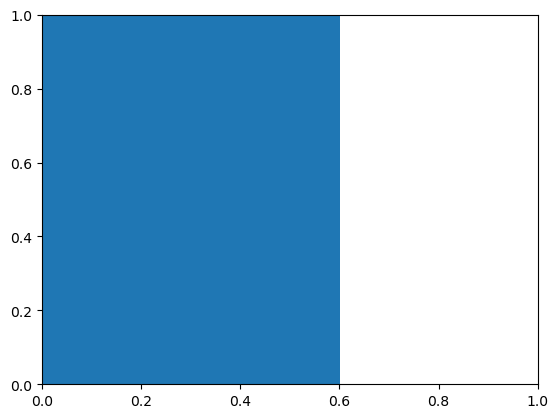

In [21]:
#plot a bar chart for all the features
def plot_bar_chart(x_processed):
    """plot a bar chart for all the features"""
    for i in range(len(x_processed[0])):
        plt.figure()
        plt.bar(np.unique(x_processed[:, i]), np.unique(x_processed[:, i], return_counts=True)[1])
        plt.savefig('distributions/feature_' + str(i) + '.png')
        plt.close()

plot_bar_chart(x_processed)

### Now that the preprocessing has been done, we can format the data to be used by the algorithms

In [22]:
tX = np.c_[np.ones((len(y_processed), 1)), x_processed]


## And then, we can run the algorithms

1. MSE gradient descent

In [23]:
loss_mse_gd, w_mse_gd = mean_squared_error_gd(y_processed, tX, np.zeros(len(tX[0])), 100, 0.4)

Gradient Descent(0/99): loss=0.047004910843246935, w0=0.03760392867459755, w1=0.12672601696473124
Gradient Descent(1/99): loss=36.76077512526498, w0=-3.039854451785894, w1=-8.456679244281435
Gradient Descent(2/99): loss=220525.19222681606, w0=236.4691996775179, w1=657.6872405062514
Gradient Descent(3/99): loss=1326362252.9146895, w0=-18352.09968365851, w1=-51009.08748761444
Gradient Descent(4/99): loss=7977931286012.0205, w0=1423611.556857921, w1=3956254.445345346
Gradient Descent(5/99): loss=4.798654230630449e+16, w0=-110417050.66433658, w1=-306837380.5773361
Gradient Descent(6/99): loss=2.8863478961473117e+20, w0=8563690316.938741, w1=23797238308.898163
Gradient Descent(7/99): loss=1.7361126359888716e+24, w0=-664169748791.807, w1=-1845621073491.0652
Gradient Descent(8/99): loss=1.044256339003108e+28, w0=51510401252621.72, w1=143138891349229.6
Gradient Descent(9/99): loss=6.281109180563829e+31, w0=-3994937381734486.0, w1=-1.1101264209057282e+16
Gradient Descent(10/99): loss=3.77803141

c:\Users\croge\anaconda3\envs\ML\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\croge\AppData\Local\Temp\ipykernel_24832\1574709863.py:4: RuntimeWarning: overflow encountered in square
  mse = 1/(2*len(y)) * np.sum(e**2)
C:\Users\croge\AppData\Local\Temp\ipykernel_24832\1574709863.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  if  n_iter > 1 and np.abs(loss - compute_mse(y, tx, w)) < 1e-7:


Gradient Descent(87/99): loss=inf, w0=-9.805051535109366e+162, w1=-2.7246593129481898e+163
Gradient Descent(88/99): loss=inf, w0=7.604391921280049e+164, w1=2.1131329288207157e+165
Gradient Descent(89/99): loss=inf, w0=-5.897651459083847e+166, w1=-1.6388583899815205e+167
Gradient Descent(90/99): loss=inf, w0=4.573974236585442e+168, w1=1.2710306984387123e+169
Gradient Descent(91/99): loss=inf, w0=-3.547384999281973e+170, w1=-9.857587734543738e+170
Gradient Descent(92/99): loss=inf, w0=2.7512049002105536e+172, w1=7.645136821918579e+172
Gradient Descent(93/99): loss=inf, w0=-2.133720586988644e+174, w1=-5.929251516680623e+174
Gradient Descent(94/99): loss=inf, w0=1.6548253250750967e+176, w1=4.598481932627671e+176
Gradient Descent(95/99): loss=inf, w0=-1.283413992070407e+178, w1=-3.566392153413212e+178
Gradient Descent(96/99): loss=inf, w0=9.953627431749259e+179, w1=2.765946061825532e+180
Gradient Descent(97/99): loss=inf, w0=-7.719621233850187e+181, w1=-2.1451532214723797e+182
Gradient Desc

In [24]:
tX_test = np.c_[np.ones((x_test_processed.shape[0], 1)), x_test_processed]
y_test = tX_test.dot(w_mse_gd)
y_test_rounded = np.where(y_test > 0.5, 1, 0)

print('weights = \n', w_mse_gd,'\n Loss = ', loss_mse_gd,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.sum(y_processed)/len(y_processed), '\n \n Test sample : \n', 'Heart attack rate = ', np.sum(y_test_rounded)/len(y_test_rounded))

weights = 
 [-4.64328365e+185 -1.29029062e+186 -3.68895471e+186 -2.53891234e+186
 -2.08586974e+184 -4.17430066e+185 -2.47827914e+185 -4.38637196e+185
 -7.56475503e+185 -2.66607947e+185 -2.32736952e+186 -2.72961234e+186
 -3.47255084e+185 -2.43840714e+185 -2.41804923e+185 -4.48943739e+185
 -3.92375168e+186 -1.33373477e+185 -4.38782233e+185 -1.72971536e+185
 -9.20409614e+184 -1.33069781e+185] 
 Loss =  inf 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.09400982168649387 
 
 Test sample : 
 Heart attack rate =  0.0


In [25]:
h.create_csv_submission(ids_processed, y_test_rounded, 'submission_mse_gd.csv')

2. MSE SGD

In [26]:
loss_mse_sgd, w_mse_sgd = mean_squared_error_sgd(y_processed, tX, np.zeros(len(tX[0])), 300, 0.05)

Gradient Descent(0/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(1/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(2/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(3/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(4/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(5/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(6/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(7/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(8/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(9/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(10/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(11/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(12/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(13/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(14/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(15/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(16/299): loss=0.0, w0=0.0, w1=0.0
Gradient Descent(17/299): loss=0.5, w0=0.05, w1=0.15000000000000002
Gradient Descent(18/299): loss=16.27227965858765, w0=-0.23523919487500006, 

C:\Users\croge\AppData\Local\Temp\ipykernel_24832\1574709863.py:4: RuntimeWarning: overflow encountered in square
  mse = 1/(2*len(y)) * np.sum(e**2)


Gradient Descent(214/299): loss=inf, w0=3.4217564749466915e+158, w1=1.1263759183274862e+159
Gradient Descent(215/299): loss=inf, w0=-2.441455395930598e+159, w1=-4.440886168523048e+159
Gradient Descent(216/299): loss=inf, w0=1.2403730376787408e+160, w1=4.009467114963097e+160
Gradient Descent(217/299): loss=inf, w0=-6.297010938849546e+160, w1=-1.860268481462176e+161
Gradient Descent(218/299): loss=inf, w0=8.621528828074275e+161, w1=2.589342128441551e+162
Gradient Descent(219/299): loss=inf, w0=-6.270627596738209e+162, w1=-1.1676218830649722e+163
Gradient Descent(220/299): loss=inf, w0=4.561299712717303e+163, w1=1.9585828006499521e+164
Gradient Descent(221/299): loss=inf, w0=-2.4104767817407695e+164, w1=-6.641237458387548e+164
Gradient Descent(222/299): loss=inf, w0=1.9988044825656256e+165, w1=3.81558057564065e+165
Gradient Descent(223/299): loss=inf, w0=-1.2779278106404563e+166, w1=-1.0962502013329538e+166
Gradient Descent(224/299): loss=inf, w0=6.084068532282987e+166, w1=2.0989738827437

In [27]:
y_test_sgd = tX_test.dot(w_mse_sgd)
y_test_rounded_sgd = np.where(y_test_sgd > 0.5, 1, 0)

print('weights = \n', w_mse_sgd,'\n Loss = ', loss_mse_sgd,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.sum(y_processed)/len(y_processed), '\n \n Test sample : \n', 'Heart attack rate = ', np.sum(y_test_rounded_sgd)/len(y_test_rounded_sgd))

weights = 
 [ 3.65464177e+226  5.83900106e+226 -1.47101686e+227 -6.42822596e+226
  9.55458055e+215  4.15034726e+226  3.65417035e+226  3.64952498e+226
  7.30918924e+226  3.65464119e+226  2.24129594e+227  1.82787638e+227
  4.14498066e+226  3.64952497e+226  4.14498605e+226  3.65464177e+226
  1.26617631e+227  1.00459101e+226  3.65464177e+226  4.15014941e+226
  5.43272905e+223  3.65464657e+226] 
 Loss =  inf 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.09400982168649387 
 
 Test sample : 
 Heart attack rate =  0.9091569882278581


3. Least squares

In [28]:
loss_ls, w_ls = least_squares(y_processed, tX)

In [29]:
y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0.5, 1, 0)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.sum(y_processed)/len(y_processed), '\n \n Test sample : \n', 'Heart attack rate = ', np.sum(y_test_ls)/len(y_test_ls))

weights = 
 [ 2.88270844e-01  3.34614524e-02  9.21278281e-04 -1.44338604e-04
 -8.63464839e-03 -7.29891263e-03 -3.81292266e-02 -1.86529550e-01
 -2.16648865e-02 -5.30251829e-02  5.15199746e-04 -3.45976029e-03
 -4.98852632e-02 -2.27719764e-02 -3.36538051e-02  1.34630336e-02
  1.11543984e-02 -1.18266627e-01  1.93466354e-02 -3.03311985e-03
 -4.04505447e-03 -4.58582529e-03] 
 Loss =  0.036280746857273415 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.09400982168649387 
 
 Test sample : 
 Heart attack rate =  0.0036185509994469465


4. Ridge regression

In [30]:
loss_ridge, w_ridge = ridge_regression(y_processed, tX, 0.1)

In [31]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0.5, 1, 0)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.sum(y_processed)/len(y_processed), '\n \n Test sample : \n', 'Heart attack rate = ', np.sum(y_test_ridge)/len(y_test_ridge))

weights = 
 [ 3.11737536e-03  3.46261813e-02  1.98772957e-03  1.35255466e-04
 -1.07511427e-03 -5.01489595e-04 -2.27049733e-02 -2.85666601e-02
 -1.75867462e-02 -2.91627752e-02  1.83612644e-03 -4.09446645e-03
 -1.72798416e-02 -1.44256542e-02 -2.09755449e-02  5.41065993e-03
  1.49365519e-02 -7.29866288e-05  6.12963375e-03  7.61692000e-04
  5.64658737e-04  1.23394440e-05] 
 Loss =  0.037031163716580585 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.09400982168649387 
 
 Test sample : 
 Heart attack rate =  0.0


5. ridge & least square polynomial regression

In [33]:
loss_polyridge, w_polyridge = poly_ridge_ls(y_processed, tX, lambda_=0.1, ridge_y=True, degree = 5)
y_test_polyridge = tX_test.dot(w_polyridge)
y_test_polyridge = np.where(y_test_ridge > 0.5, 1, 0)

print('weights = \n', w_polyridge,'\n Loss = ', loss_polyridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.sum(y_processed)/len(y_processed), '\n \n Test sample : \n', 'Heart attack rate = ', np.sum(y_test_polyridge)/len(y_test_polyridge))

ValueError: setting an array element with a sequence.

In [34]:
loss_log, w_log = logistic_regression(y_processed, tX, 100, 0.05, np.zeros(len(tX[0])))

y_test_log = tX_test.dot(w_log)
print(y_test_log)
y_test_log = np.where(y_test_log > 0.5, 1, 0)

print('weights = \n', w_log,'\n Loss = ', loss_log,'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.sum(y_processed)/len(y_processed), '\n \n Test sample : \n', 'Heart attack rate = ', np.sum(y_test_log)/len(y_test_log))

Gradient Descent(0/99): loss=131971.75744271078, w0=-3864.925, w1=-8937.35
Gradient Descent(1/99): loss=13220108440.281887, w0=-2969.9750000000004, w1=-5921.35
Gradient Descent(2/99): loss=8796184655.56768, w0=-2075.0250000000005, w1=-2905.3500000000004
Gradient Descent(3/99): loss=inf, w0=-1181.1750000000006, w1=107.25


C:\Users\croge\AppData\Local\Temp\ipykernel_24832\1574709863.py:153: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-t))
C:\Users\croge\AppData\Local\Temp\ipykernel_24832\1574709863.py:148: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(pred))) - y.T.dot(pred)


Gradient Descent(4/99): loss=inf, w0=-1773.76871250558, w1=-2479.2658548514974
Gradient Descent(5/99): loss=6315118752.377287, w0=-878.8187125055799, w1=536.7341451485026
Gradient Descent(6/99): loss=inf, w0=-10.11861971797964, w1=3467.6344235113033
Gradient Descent(7/99): loss=inf, w0=-8205.589528150862, w1=-16649.306846080854
Gradient Descent(8/99): loss=27561854441.0885, w0=-7310.639528150862, w1=-13633.306846080854
Gradient Descent(9/99): loss=23137930656.37429, w0=-6415.689528150862, w1=-10617.306846080854
Gradient Descent(10/99): loss=18714006871.660084, w0=-5520.7395281508625, w1=-7601.306846080854
Gradient Descent(11/99): loss=14290083086.945877, w0=-4625.789528150863, w1=-4585.306846080854
Gradient Descent(12/99): loss=9866159302.23167, w0=-3730.839528150863, w1=-1569.3068460808536
Gradient Descent(13/99): loss=inf, w0=-3105.290240828228, w1=318.391122284851
Gradient Descent(14/99): loss=inf, w0=-3005.294878538777, w1=106.22256529202349
Gradient Descent(15/99): loss=5262963072